# Data Merge Project Script

This script handles merging cleaned versions of the AirBnB Toronto and Yelp Business datasets. For details on how I created those datasets refer to this notebook: https://github.com/jkarpen/Springboard_Projects/blob/master/Capstone/Scripts/Capstone_DataWrangling_Script.ipynb 

In [1]:
#import libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
#allow all columns to be viewed:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
current_path = % pwd
#print(current_path)

In [ ]:
#If current_path is in Scripts folder, 
#go up one level so we can open the data folder
if (current_path.rsplit('\\', 1)[1] == 'Scripts'):
    % cd ..
    #% pwd

In [4]:
#Import data

#Read in AirBnB cleaned listing data for Toronto
path1='../Capstone/Data/listings_clean.csv'
abb = pd.read_csv(path1)

#Read in Yelp cleaned business data for Toronto
path2='../Capstone/Data/yelp_clean.csv'
yelp = pd.read_csv(path2)

print(abb.shape)
print(yelp.shape)

(16947, 53)
(14023, 6)


## Fix Missing Neighborhoods and Mismatches

The ultimate goal is to use the keep the AirBnB listings dataset and merge in for each listing the total number of businesses, their average star rating, and the number of reviews, for all Yelp businesses within 0.1 miles of the AirBnB listing. Without any other filtering this would involve comparing the lat/long of every single AirBnB listing (16,947) against every Yelp business (14,023). This could be very time-consuming. 

To limit the number of comparisons and make the process more manageable I plan to only compare listings in the same neighborhood, which is a variable in both datasets. There were a significant number of missing neighborhood values in each dataset, so my next step will be to use K Nearest Neighbors to predict those missing values so those records can be used. 

### Rename Mismatched Neighborhoods
First I will inspect the neighborhoods in each dataset and check how many match or do not match in each dataset. 

In [5]:
abb_hoods = pd.DataFrame(abb['neighbourhood'].value_counts().reset_index())
yelp_hoods = pd.DataFrame(yelp['neighborhood'].value_counts().reset_index())
print(abb_hoods.shape)
print(yelp_hoods.shape)
print(abb_hoods.head())
print(yelp_hoods.head())

(140, 2)
(80, 2)
                    index  neighbourhood
0        Downtown Toronto           2082
1  Entertainment District           1571
2                 Unknown            855
3                 Niagara            696
4              Willowdale            504
           index  neighborhood
0        Unknown          2842
1  Downtown Core          1317
2    Scarborough           717
3      Etobicoke           601
4      Yorkville           419


In [6]:
#Next check how many neighborhood matches there are between datasets:
match_hoods = pd.merge(abb_hoods, yelp_hoods, 
                       on=['index'], how='outer')

In [7]:
#Count records where there is no match on each side.
abb_nomatch = match_hoods.neighbourhood[match_hoods.neighborhood.isnull()]
print('There are ' + str(abb_nomatch.sum()) + ' AirBnB listings with no match in the Yelp data.')

yelp_nomatch = match_hoods.neighborhood[match_hoods.neighbourhood.isnull()]
print('There are ' + str(yelp_nomatch.sum()) + ' Yelp listings with no match in the AirBnB data.')


There are 9554.0 AirBnB listings with no match in the Yelp data.
There are 7077.0 Yelp listings with no match in the AirBnB data.


It seems there are quite a few mismatches. 9,554 out of approx. 17K records in the AirBnB dataset do not have a neighborhood match in the Yelp dataset, which is approximately 56%. On the other side 7,077 Yelp listings out of approx. 14K do not have a neighborhood match on the AirBnB side, which is around 50%. Eventually I will drop the Yelp records that don't have a match, but first I will manually inspect the names to see if there are any neighborhoods that are simply named differently in each dataset. 

In [8]:
#View matches and mismatches side by side. 
#neighbourhood column shows the count of records in the AirBnB dataset
#neighborhood (no "u") shows the count of records in the Yelp dataset. 
#NaN in neighbourhood column indicates a name that exists in Yelp but not AirBnB.
#NaN in neighborhood column indicates a name that exists in AirBnB but not Yelp. 
print(match_hoods.sort_values('index'))

                             index  neighbourhood  neighborhood
37                       Agincourt          103.0           NaN
95                       Alderwood           32.0           NaN
155                 Alexandra Park            NaN         116.0
108                       Amesbury           26.0           NaN
76                  Armour Heights           42.0           NaN
73                         Bayview           44.0           NaN
75                 Bayview Village           42.0          34.0
174           Beaconsfield Village            NaN          58.0
89                    Bedford Park           35.0           NaN
83                         Bendale           40.0           NaN
162                  Bickford Park            NaN          82.0
67                     Birch Cliff           49.0           NaN
153             Bloor-West Village            NaN         137.0
168              Bloordale Village            NaN          73.0
70                 Broadview North      

In [9]:
#Checking neighbourhood against neighbourhood_cleansed in the AirBnB dataset might also provide context
print(abb[['neighbourhood_cleansed', 'neighbourhood']].drop_duplicates().sort_values(by=['neighbourhood_cleansed', 'neighbourhood']))

                    neighbourhood_cleansed            neighbourhood
881                        Agincourt North                Agincourt
13889                      Agincourt North                  Unknown
322           Agincourt South-Malvern West                Agincourt
2170          Agincourt South-Malvern West             Malvern West
1476                             Alderwood                Alderwood
10877                            Alderwood                  Unknown
12331                                Annex                Casa Loma
1070                                 Annex         Downtown Toronto
2707                                 Annex  Palmerston/Little Italy
3488                                 Annex                 Rosedale
2                                    Annex                The Annex
463                                  Annex                  Unknown
256                                  Annex                Yorkville
308                      Banbury-Don Mills      

Inspecting the list shows a few obvious misnamings: The Beach in Yelp, The Beaches in AirBnB, for example. Where I see these I will correct the spelling in the Yelp dataset to match the AirBnB dataset. 

Others are not as obvious. The Yelp dataset has Scarborough neighborhood, while the AirBnB dataset has Scarborough City Centre, Scarborough Junction, and Scarborough Village. Consulting Wikipedia (https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto) it seems safe to group these together under Scarborough, along with other neighborhoods like Tam O'Shanter.

Before renaming anything, I will create a derived feature that tells me if the host lives in the same neighborhood as their listing by comparing host_neighbourhood to neighbourhood. This will not work after renaming neighborhoods. 

In [28]:
abb['host_lives_near_listing'] = abb['neighbourhood'] == abb['host_neighbourhood']

In [29]:
#Rename Scarborough Neighborhoods as Scarborough in AirBnB
abb.neighbourhood.replace(['Agincourt', 'Scarborough Village', 'Tam O\'Shanter', 
                          'Scarborough Junction', 'Scarborough City Centre', 'Bendale', 'Birch Cliff',
                          'Clairlea', 'Cliffcrest', 'Dover Park', 'Cliffside', 'Dorset Park', 'Eglinton East',
                          'Guildwood', 'Highland Creek', 'Ionview', 'L\'Amoreaux', 'Malvern', 'Malvern West',
                          'Morningside', 'Morningside Heights', 'Oakridge', 'Port Union', 'Rouge', 'West Hill',
                          'West Rouge', 'Wexford/Maryvale', 'Woburn', 'Manse Valley', 'Milliken'],
                        'Scarborough', inplace=True)

In [30]:
#Rename Etobicoke Neighborhoods as Etobicoke in AirBnB
abb.neighbourhood.replace(['Etobicoke West Mall', 'Alderwood', 'Eringate', 'Humber Valley', 'Islington', 'Long Branch',
                          'Mimico', 'Princess', 'Richview', 'Stonegate-Queensway', 'The Elms', 'The Kingsway', 
                           'The Westway', 'Thistletown', 'West Humber', 'Westmount'],
                        'Etobicoke', inplace=True)

In [46]:
#Rename Downtown Core Neighborhoods as Downtown Core in AirBnB
abb.neighbourhood.replace(['Downtown Toronto', 'Fashion District', 'Garden District', 'Saint Andrew/Windfields',
                          'Toronto Islands', 'Studio District'],
                        'Downtown Core', inplace=True)

In [32]:
#Rename East York neighborhoods as East York in AirBnB
abb.neighbourhood.replace(['Broadview North', 'Crescent Town', 'Old East York', 'Parkview', 'Thorncliffe Park',
                          'Flemingdon Park'],
                        'East York', inplace=True)

In [65]:
#Miscellaneous AirBnB Renamings
abb.neighbourhood.replace(['Bedford Park'],
                        'Lawrence Park', inplace=True)
abb.neighbourhood.replace(['Greek Town', 'The Pocket'],
                        'Greektown', inplace=True)
abb.neighbourhood.replace(['Humberlea'],
                        'Pelmo Park', inplace=True)
abb.neighbourhood.replace(['Markland Woods'],
                        'Markland Wood', inplace=True)
abb.neighbourhood.replace(['South Hill/Rathnelly'],
                        'South Hill', inplace=True)
abb.neighbourhood.replace(['Danforth Village', 'Woodbine/Lumsden'],
                        'The Danforth', inplace=True)
abb.neighbourhood.replace(['Bayview', 'Henry Farm', 'Don Valley Village', 'Hillcrest Village'],
                        'Bayview Village', inplace=True)
abb.neighbourhood.replace(['Cedarvale Humewood'],
                        'Wychwood', inplace=True)
abb.neighbourhood.replace(['Financial District', 'Harbourfront'],
                        'Entertainment District', inplace=True)
abb.neighbourhood.replace(['Forest Hill', 'Lytton Park'],
                        'Yonge Eglinton', inplace=True)
abb.neighbourhood.replace(['Greenwood-Coxwell'],
                        'Greektown', inplace=True)
abb.neighbourhood.replace(['Runnymede', 'Lambton Baby Point'],
                        'High Park North', inplace=True)
abb.neighbourhood.replace(['Leaside', 'Sunnybrook'],
                        'Davisville', inplace=True)
abb.neighbourhood.replace(['Markland Wood'],
                        'Etobicoke', inplace=True)
abb.neighbourhood.replace(['Newtonbrook'],
                        'Willowdale', inplace=True)
abb.neighbourhood.replace(['Woodbine Corridor'],
                        'The Beaches', inplace=True)
abb.neighbourhood.replace(['Wychwood Park', 'Fairbank', 'Oakwood'],
                        'Wychwood', inplace=True)

In [52]:
#Rename Downtown Core Neighborhoods as Downtown Core in Yelp
yelp.neighborhood.replace(['Alexandra Park', 'Chinatown', 'Christie Pits', 'Church-Wellesley Village', 'City Place',
                          'Discovery District', 'Distillery District', 'Financial District', 'Queen Street West', 'Hanlan',
                          'Koreatown', 'Leslieville', 'Ryerson', 'University of Toronto'],
                        'Downtown Core', inplace=True)

In [35]:
#Rename Scarborough Neighborhoods as Scarborough in Yelp
yelp.neighborhood.replace(['Milliken'],
                         'Scarborough', inplace=True)

In [43]:
#Rename Palmerston/Little Italy neighborhoods as Palmerston/Little Italy in Yelp
yelp.neighborhood.replace(['Palmerston', 'Little Italy', 'Seaton Village'],
                        'Palmerston/Little Italy', inplace=True)

In [58]:
#Miscellaneous Yelp Renamings
yelp.neighborhood.replace(['Bickford Park'],
                        'Palmerston/Little Italy', inplace=True)
yelp.neighborhood.replace(['Dovercourt'],
                        'Dovercourt Park', inplace=True)
yelp.neighborhood.replace(['High Park'],
                        'High Park North', inplace=True)
yelp.neighborhood.replace(['Mount Pleasant and Davisville'],
                        'Davisville', inplace=True)
yelp.neighborhood.replace(['St. Lawrence'],
                        'Saint Lawrence', inplace=True)
yelp.neighborhood.replace(['The Beach'],
                        'The Beaches', inplace=True)
yelp.neighborhood.replace(['Trinity Bellwoods'],
                        'Trinity-Bellwoods', inplace=True)
yelp.neighborhood.replace(['Yonge and St. Clair', 'Moore Park'],
                        'Deer Park', inplace=True)
yelp.neighborhood.replace(['Yonge and Eglinton'],
                        'Yonge Eglinton', inplace=True)
yelp.neighborhood.replace(['Beaconsfield Village', 'Ossington Strip'],
                        'Little Portugal', inplace=True)
yelp.neighborhood.replace(['Bloor-West Village'],
                        'Swansea', inplace=True)
yelp.neighborhood.replace(['Corso Italia'],
                        'Wychwood', inplace=True)
yelp.neighborhood.replace(['Bloordale Village'],
                        'Dovercourt Park', inplace=True)
yelp.neighborhood.replace(['Brockton Village'],
                        'Palmerston/Little Italy', inplace=True)
yelp.neighborhood.replace(['Harbourfront'],
                        'Entertainment District', inplace=True)
yelp.neighborhood.replace(['Liberty Village', 'West Queen West'],
                        'Niagara', inplace=True)
yelp.neighborhood.replace(['Markland Wood'],
                        'Etobicoke', inplace=True)
yelp.neighborhood.replace(['Summer Hill'],
                        'Yorkville', inplace=True)
yelp.neighborhood.replace(['Upper Beach'],
                        'The Beaches', inplace=True)
yelp.neighborhood.replace(['West Don Lands'],
                        'Corktown', inplace=True)


In [66]:
#Check matches again
abb_hoods = pd.DataFrame(abb['neighbourhood'].value_counts().reset_index())
yelp_hoods = pd.DataFrame(yelp['neighborhood'].value_counts().reset_index())
match_hoods = pd.merge(abb_hoods, yelp_hoods, 
                       on=['index'], how='outer')
#Count records where there is no match on each side.
abb_nomatch = match_hoods.neighbourhood[match_hoods.neighborhood.isnull()]
print('There are ' + str(abb_nomatch.sum()) + ' AirBnB listings with no match in the Yelp data.')

yelp_nomatch = match_hoods.neighborhood[match_hoods.neighbourhood.isnull()]
print('There are ' + str(yelp_nomatch.sum()) + ' Yelp listings with no match in the AirBnB data.')

print(match_hoods.sort_values('index'))

There are 1007.0 AirBnB listings with no match in the Yelp data.
There are 7.0 Yelp listings with no match in the AirBnB data.
                      index  neighbourhood  neighborhood
54                 Amesbury           26.0           NaN
46           Armour Heights           42.0           NaN
14          Bayview Village          322.0          34.0
23              Cabbagetown          217.0          76.0
55                Casa Loma           26.0          25.0
45             Clanton Park           49.0           NaN
49                 Corktown           34.0         236.0
12               Davisville          333.0         280.0
37                Deer Park           63.0         135.0
41                Don Mills           54.0           NaN
21          Dovercourt Park          224.0         149.0
38                Downsview           62.0          50.0
0             Downtown Core         2932.0        3160.0
28           Dufferin Grove          166.0          96.0
24                

In [75]:
#Drop records in each dataset where no neighborhood match exists
#This will drop 6% of AirBnB listings, approx 1000 out of 17000 records. I could impute the Yelp metrics for these
#... but I don't think it would be representative to impute records for the suburbs based on downtown.
#Only 7 Yelp records are ummatched which is a small number to drop.
abb_drop_hoods = ['Amesbury', 'Armour Heights', 'Clanton Park', 'Don Mills', 'Glen Park',
                  'Humber Summit', 'Humbermede', 'Jane and Finch', 'Keelesdale', 'Mount Dennis', 
                  'Mount Olive', 'North Park', 'Nortown', 'Oakwood', 'Parkwoods', 'Pellam Park', 'Pelmo Park',
                  'Pleasant View', 'Rockcliffe Smythe','Victoria Village', 'Westminster/Branson', 
                  'Weston', 'York University Heights']
                  
yelp_drop_hoods = ['Edgeley', 'Erin Mills', 'Langstaff', 'Meadowvale Village', 'Mississauga Valley',
                  'Thornhill']

abb = abb[~abb['neighbourhood'].isin(abb_drop_hoods)]
yelp = yelp[~yelp['neighborhood'].isin(yelp_drop_hoods)]

### Imputing Missing Neighborhoods with KNN
Previously in the Data Wrangling script I renamed missing Neighborhood values with "Unknown". I now plan to predict the value for those neighborhoods by using K Nearest Neighbors. First I will create a single data frame with the Neighborhoods and Lat/Longs from both the AirBnB and Yelp datasets. Then I will split the data frame into "train" and "test" datasets. The test dataset will include all neighborhoods with the value "Unknown". Next I will run K Nearest Neighbors on the train dataset and use the resulting model to predict the values in the test dataset. 


In [76]:
#Create dfs with neighborhood, lat, long from each dataset
abb_hoods_df = abb[['id', 
                    'neighbourhood', 'latitude', 'longitude']]
abb_hoods_df = abb_hoods_df.rename(columns={'neighbourhood':'neighborhood'})
print(abb_hoods_df.head())
yelp_hoods_df = yelp[['business_id', 
                      'neighborhood', 'latitude', 'longitude']]
print(yelp_hoods_df.head())

      id       neighborhood   latitude  longitude
0   1419    Little Portugal  43.646168 -79.424510
1  10314          Riverdale  43.670186 -79.335848
2  12604          The Annex  43.667241 -79.415978
3  17936  Kensington Market  43.656400 -79.403295
4  23691           Wychwood  43.696017 -79.454683
              business_id   neighborhood   latitude  longitude
0  5J3b7j3Fzo9ISjChmoUoUA       Wychwood  43.681328 -79.427884
1  zHwXoh40k86P0aiN1aix9Q    Scarborough  43.733395 -79.224206
2  wv9KN5x8L2qzKFq_6Hzf9g  Downtown Core  43.661964 -79.391259
3  RJEtBRLJmmji_QoqS6ysjg  Downtown Core  43.667749 -79.396167
4  YIez_A3WOt9J2SXN7OMa2Q        Unknown  43.745928 -79.324623


In [77]:
neighborhoods_df = pd.concat([abb_hoods_df, yelp_hoods_df], sort=True)
neighborhoods_df.shape

(29956, 5)

In [78]:
#Remove Unknown neighborhoods
neighborhoods_df = neighborhoods_df[neighborhoods_df['neighborhood'] != 'Unknown']
print(neighborhoods_df.head())
print(neighborhoods_df.shape)

  business_id       id   latitude  longitude       neighborhood
0         NaN   1419.0  43.646168 -79.424510    Little Portugal
1         NaN  10314.0  43.670186 -79.335848          Riverdale
2         NaN  12604.0  43.667241 -79.415978          The Annex
3         NaN  17936.0  43.656400 -79.403295  Kensington Market
4         NaN  23691.0  43.696017 -79.454683           Wychwood
(26259, 5)


In [79]:
#Convert neighborhoods to numeric for prediction
le = preprocessing.LabelEncoder()
le.fit(neighborhoods_df['neighborhood'].astype(str)) #fit to list of all neighborhoods to ensure all possible values are encoded

LabelEncoder()

In [80]:
#Create train/test split from neighborhoods_df
x = neighborhoods_df[['latitude', 'longitude']]
y = neighborhoods_df[['neighborhood', 'business_id', 'id']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [81]:
y_train['neighborhood'] = le.transform(y_train['neighborhood'].astype(str))
y_test['neighborhood'] = le.transform(y_test['neighborhood'].astype(str))
#print(y_train)
#Code below converts back to original values
#print("")
#y_train['neighborhood'] = le.inverse_transform(y_train['neighborhood'])
#print(y_train)

C:\Users\jshka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jshka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [82]:
# Scale lat/long before modeling
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [83]:
# Run K Means on training set
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train.loc[:, 'neighborhood'].values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [84]:
#Make predictions
y_pred = classifier.predict(x_test)

In [85]:
# Evaluate model
print(confusion_matrix(y_test.loc[:, 'neighborhood'], y_pred))
print(classification_report(y_test.loc[:, 'neighborhood'], y_pred))

[[ 70   0   0 ...   0   0   0]
 [  0  56   0 ...   0   0   0]
 [  0   0  10 ...   0   0   0]
 ...
 [  0   0   3 ... 138   0   0]
 [  0   0   0 ...   0  76   0]
 [  0   0   0 ...   0   0 134]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        70
          1       0.84      0.93      0.88        60
          2       0.77      0.91      0.83        11
          3       0.78      0.65      0.71        60
          4       0.95      0.91      0.93       125
          5       0.95      0.97      0.96        40
          6       0.88      0.94      0.91        87
          7       1.00      1.00      1.00        28
          8       0.93      0.95      0.94      1171
          9       0.90      0.84      0.87        43
         10       0.95      0.95      0.95        58
         11       0.97      0.96      0.97       483
         12       1.00      0.99      0.99       290
         13       0.83      0.80      0.81        79
         14 

The above predictions were great, but I want to confirm I used the best value for K. Possibly setting 5 as the n_neighbors parameter was not the best value, so I will try  the below loop to test multiple values and use a plot to determine the best outcome. 

In [86]:
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(x_train, y_train.loc[:, 'neighborhood'].values.ravel())
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test.loc[:, 'neighborhood']))

Text(0,0.5,'Mean Error')

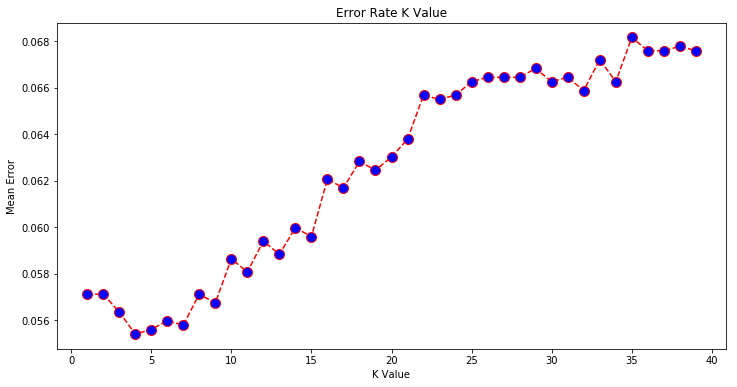

In [87]:
#Plot the errors against the various k values
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
        markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

K=4 seems to do the best with around 0.05 mean error. I will change the parameter and run it one more time, then use the model to predict the "Unknown" values. 

In [88]:
# Run K Means on training set, this time setting n_neighbors to optimal value
classifier = KNeighborsClassifier(n_neighbors=4, weights='distance')
classifier.fit(x_train, y_train.loc[:, 'neighborhood'].values.ravel())

#Make predictions
y_pred = classifier.predict(x_test)

### Predict neighborhood in AirBnB dataset

In [89]:
#Use the model to predict the Unknown neighborhoods in AirBnB data.
abb_copy = abb.loc[abb['neighbourhood']=='Unknown', ['id', 'latitude', 'longitude', 'neighbourhood']]

#Transform
abb_copy[['latitude', 'longitude']] = scaler.transform(abb_copy[['latitude', 'longitude']])

#Create a new column containing transformed values of neighbourhood
abb_copy['neighborhood'] = None

In [90]:
#Predict values of neighborhood
abb_copy['neighborhood'] = classifier.predict(abb_copy[['latitude', 'longitude']])

#Convert neighborhood back to original text values (instead of numeric)
abb_copy['neighborhood'] = le.inverse_transform(abb_copy['neighborhood'])

C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [91]:
#Merge predicted neighborhood back into abb
abb = pd.merge(abb, abb_copy, how='outer', on='id')

In [92]:
#Replace unknown values
abb.loc[abb['neighbourhood_x']=='Unknown', 'neighbourhood_x'] = abb.loc[abb['neighbourhood_x']=='Unknown', 'neighborhood']

In [93]:
#Drop unecessary columns
abb.drop(columns=['latitude_y', 'longitude_y', 'neighbourhood_y', 'neighborhood'], inplace=True)
abb.head()

,id,listing_url,picture_url,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_verifications,neighbourhood_x,neighbourhood_cleansed,latitude_x,longitude_x,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,square_feet_notNA,monthly_price_notNA,weekly_price_notNA,bathrooms_notNA,beds_notNA,bedrooms_notNA,security_deposit_notNA,cleaning_fee_notNA,host_response_rate_notNA,reviews_per_month_notNA,neighbourhood_notNA,host_neighbourhood_notNA,neighbourhood_cleansed_notNA,host_response_time_notNA,host_is_superhost_notNA,host_lives_near_listing
0,1419,https://www.airbnb.com/rooms/1419,https://a0.muscache.com/im/pictures/76206750/d...,within an hour,0.0,f,Commercial Drive,"['email', 'phone', 'reviews', 'jumio', 'govern...",Little Portugal,Little Portugal,43.646168,-79.424510,f,House,Entire home/apt,6.0,2.0,3.0,4.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",470.0,1000.0,150.0,1.0,0.0,4.0,6 months ago,t,0,0,0,0,f,strict_14_with_grace_period,f,f,0.19,True,False,True,True,True,True,True,True,False,True,True,True,True,False,True,False
1,10314,https://www.airbnb.com/rooms/10314,https://a0.muscache.com/im/pictures/53300435/4...,within an hour,0.0,f,Riverdale,"['email', 'phone', 'reviews', 'jumio', 'govern...",Riverdale,South Riverdale,43.670186,-79.335848,t,House,Private room,2.0,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,""Free parking...",69.0,0.0,0.0,2.0,20.0,1.0,11 months ago,t,0,0,21,296,f,moderate,f,f,0.71,False,True,True,True,True,True,False,False,False,True,True,True,True,False,True,True
2,12604,https://www.airbnb.com/rooms/12604,https://a0.muscache.com/im/pictures/5282025/91...,within an hour,0.0,f,The Annex,"['email', 'phone', 'reviews', 'jumio', 'govern...",The Annex,Annex,43.667241,-79.415978,t,House,Private room,1.0,1.5,1.0,1.0,Pull-out Sofa,"{Internet,Wifi,""Pets live on this property"",Ca...",65.0,130.0,26.0,1.0,20.0,1.0,yesterday,t,0,0,0,0,f,moderate,f,f,0.00,True,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True
3,17936,https://www.airbnb.com/rooms/17936,https://a0.muscache.com/im/pictures/f6c169b4-4...,within an hour,100.0,t,Kensington Market,"['email', 'phone', 'facebook', 'reviews', 'jum...",Kensington Market,Kensington-Chinatown,43.656400,-79.403295,t,Apartment,Private room,4.0,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",99.0,300.0,80.0,1.0,20.0,2.0,4 days ago,t,5,5,23,23,f,strict_14_with_grace_period,f,f,1.18,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,23691,https://www.airbnb.com/rooms/23691,https://a0.muscache.com/im/pictures/615528/d09...,within an hour,100.0,t,Fairbank,"['email', 'phone', 'facebook', 'reviews', 'jum...",Wychwood,Briar Hill-Belgravia,43.696017,-79.454683,t,House,Private room,2.0,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Fre...",70.0,0.0,0.0,2.0,25.0,1.0,today,t,0,10,40,315,t,strict_14_with_grace_period,f,f,2.02,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [94]:
#Rename fields changed by merge
abb = abb.rename(columns={'neighbourhood_x':'neighborhood', 'latitude_x':'latitude', 
                          'longitude_x':'longitude'})

### Predict neighborhood in Yelp dataset

In [95]:
#Use the model to predict the Unknown neighborhoods in Yelp data.
yelp_copy = yelp.loc[yelp['neighborhood']=='Unknown', ['business_id', 'latitude', 'longitude', 'neighborhood']]

#Transform
yelp_copy[['latitude', 'longitude']] = scaler.transform(yelp_copy[['latitude', 'longitude']])

#Create a new column containing transformed values of neighbourhood
yelp_copy['neighborhood'] = None

In [96]:
#Predict values of neighborhood
yelp_copy['neighborhood'] = classifier.predict(yelp_copy[['latitude', 'longitude']])

#Convert neighborhood back to original text values (instead of numeric)
yelp_copy['neighborhood'] = le.inverse_transform(yelp_copy['neighborhood'])

C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [97]:
#Merge predicted neighborhood back into yelp
yelp = pd.merge(yelp, yelp_copy, how='outer', on='business_id')

In [98]:
yelp.head()

,business_id,latitude_x,longitude_x,neighborhood_x,review_count,stars,latitude_y,longitude_y,neighborhood_y
0,5J3b7j3Fzo9ISjChmoUoUA,43.681328,-79.427884,Wychwood,23,4.0,NaN,NaN,NaN
1,zHwXoh40k86P0aiN1aix9Q,43.733395,-79.224206,Scarborough,3,2.0,NaN,NaN,NaN
2,wv9KN5x8L2qzKFq_6Hzf9g,43.661964,-79.391259,Downtown Core,3,4.5,NaN,NaN,NaN
3,RJEtBRLJmmji_QoqS6ysjg,43.667749,-79.396167,Downtown Core,3,4.5,NaN,NaN,NaN
4,YIez_A3WOt9J2SXN7OMa2Q,43.745928,-79.324623,Unknown,105,4.0,1.643945,1.125045,Scarborough


In [99]:
#Replace unknown values
yelp.loc[yelp['neighborhood_x']=='Unknown', 'neighborhood_x'] = yelp.loc[yelp['neighborhood_x']=='Unknown', 'neighborhood_y']

In [100]:
#Drop unecessary columns
yelp.drop(columns=['latitude_y', 'longitude_y', 'neighborhood_y'], inplace=True)
yelp.head()

,business_id,latitude_x,longitude_x,neighborhood_x,review_count,stars
0,5J3b7j3Fzo9ISjChmoUoUA,43.681328,-79.427884,Wychwood,23,4.0
1,zHwXoh40k86P0aiN1aix9Q,43.733395,-79.224206,Scarborough,3,2.0
2,wv9KN5x8L2qzKFq_6Hzf9g,43.661964,-79.391259,Downtown Core,3,4.5
3,RJEtBRLJmmji_QoqS6ysjg,43.667749,-79.396167,Downtown Core,3,4.5
4,YIez_A3WOt9J2SXN7OMa2Q,43.745928,-79.324623,Scarborough,105,4.0


In [101]:
#Rename fields changed by merge
yelp = yelp.rename(columns={'neighborhood_x':'neighborhood', 'latitude_x':'latitude', 
                          'longitude_x':'longitude'})

## Merge abb and yelp datasets by computing distance

In [102]:
#Function to compute distance between two lat/longs
#Adapted from: 
#https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians

def compute_distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [103]:
#Make df that’s columns airbnb_id, neighborhood, lat, long
abb_hoods = abb[['id', 'neighborhood', 'latitude', 'longitude']]
abb_hoods.head()

,id,neighborhood,latitude,longitude
0,1419,Little Portugal,43.646168,-79.424510
1,10314,Riverdale,43.670186,-79.335848
2,12604,The Annex,43.667241,-79.415978
3,17936,Kensington Market,43.656400,-79.403295
4,23691,Wychwood,43.696017,-79.454683


In [104]:
#Make df that's columns business_id, neighborhood, number of reviews, average star rating, lat, long from Yelp
yelp_hoods = yelp[['business_id', 'neighborhood', 'latitude', 
                      'longitude', 'review_count', 'stars']]
yelp.head()

,business_id,latitude,longitude,neighborhood,review_count,stars
0,5J3b7j3Fzo9ISjChmoUoUA,43.681328,-79.427884,Wychwood,23,4.0
1,zHwXoh40k86P0aiN1aix9Q,43.733395,-79.224206,Scarborough,3,2.0
2,wv9KN5x8L2qzKFq_6Hzf9g,43.661964,-79.391259,Downtown Core,3,4.5
3,RJEtBRLJmmji_QoqS6ysjg,43.667749,-79.396167,Downtown Core,3,4.5
4,YIez_A3WOt9J2SXN7OMa2Q,43.745928,-79.324623,Scarborough,105,4.0


In [106]:
#merge on neighborhood (the two dfs created above)
merge = pd.merge(abb_hoods, yelp_hoods, how='inner', on='neighborhood', suffixes = ('_abb', '_yelp'))
merge.shape

(16597895, 9)

The resulting dataset has 16,597,895 rows. This was expected as I am joining datasets with a many to many relationship. For each AirBnB listing I pulled in all Yelp businesses with a matching neighborhood, so the Yelp businesses are repeated many times. The dataset would have been much larger (potentially up to 231 million rows) if I had not matched on neighborhood and compared every AirBnB listing to every Yelp listing. Cleaning up the neighborhood names to increase matches helped too.

In [107]:
#apply function to generate distance
merge['distance'] = list(map(compute_distance, merge['latitude_abb'], 
                            merge['longitude_abb'], merge['latitude_yelp'],
                            merge['longitude_yelp']))

In [109]:
#Output full merge dataframe to a pickle file for later re-use
merge.to_pickle('full_merge.pickle')

In [110]:
merge.loc[merge['distance']>0].head()

,id,neighborhood,latitude_abb,longitude_abb,business_id,latitude_yelp,longitude_yelp,review_count,stars,distance
0,1419,Little Portugal,43.646168,-79.42451,DM6SwVs5ksGe9mWKO94Q0A,43.649112,-79.420954,51,3.5,0.434949
1,1419,Little Portugal,43.646168,-79.42451,8al-XRt5nuIize8_STWffQ,43.643191,-79.423903,53,3.5,0.334715
2,1419,Little Portugal,43.646168,-79.42451,pOe045d08sWNYEMwD7q0Vg,43.648612,-79.420612,9,3.5,0.415176
3,1419,Little Portugal,43.646168,-79.42451,k216g_LRctaecOejbFKBgw,43.649610,-79.430026,35,3.5,0.586251
4,1419,Little Portugal,43.646168,-79.42451,DAfWBoWNe_B5_lJAfYH5KQ,43.644598,-79.418873,24,4.0,0.486176


Now that I have computed distance between each AirBnB listing and all Yelp businesses in the same neighborhood, I want to create two sets of features: number of businesses, number of reviews, and average star rating, for all businesses within .1 and .5 miles. The end result should be 6 new variables.

First I need to create two new dataframes - one containing all records from merge where distance is <= .1, the other where distance is <= .5.

In [111]:
#filter for distance < .1
merge_1 = merge[merge['distance']<=.1]
#filter for distance < .5
merge_5 = merge[merge['distance']<=.5]
print(merge_1.shape)
print(merge_5.shape)

(87235, 10)
(1540600, 10)


In [112]:
#For each dataset, group by airbnb_id with count to get number of businesses in that distance 
#Also avg. star rating and number of reviews
#For everything within .1 mile:
merge_group_1 = merge_1.groupby(['id']).agg({'business_id':'count',
                                                        'review_count':'sum',
                                                        'stars':'mean'})
merge_group_1 = merge_group_1.rename(columns={'business_id':'yelp_bus_count_1', 
                                          'review_count':'yelp_bus_total_reviews_1', 
                                          'stars':'yelp_bus_avg_rating_1'})

#For everything within .5 mile:
merge_group_5 = merge_5.groupby(['id']).agg({'business_id':'count',
                                                        'review_count':'sum',
                                                        'stars':'mean'})
merge_group_5 = merge_group_5.rename(columns={'business_id':'yelp_bus_count_5', 
                                          'review_count':'yelp_bus_total_reviews_5', 
                                          'stars':'yelp_bus_avg_rating_5'})


In [114]:
#Merge merge_group_1 and merge_group_5 together
merge_both = pd.merge(merge_group_1, merge_group_5, how='right', on='id')
merge_both.head()

,yelp_bus_count_1,yelp_bus_total_reviews_1,yelp_bus_avg_rating_1,yelp_bus_count_5,yelp_bus_total_reviews_5,yelp_bus_avg_rating_5
id,,,,,,
1419,1.0,66.0,3.500000,194,9564,3.917526
17936,42.0,1789.0,3.666667,285,13604,3.707018
42892,3.0,22.0,3.000000,136,6231,3.297794
44452,26.0,426.0,3.269231,42,560,3.238095
44469,31.0,485.0,3.016129,42,560,3.238095


In [117]:
abb = pd.merge(abb, merge_both, on='id', how='left')
abb.head()

,id,listing_url,picture_url,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_verifications,neighborhood,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,square_feet_notNA,monthly_price_notNA,weekly_price_notNA,bathrooms_notNA,beds_notNA,bedrooms_notNA,security_deposit_notNA,cleaning_fee_notNA,host_response_rate_notNA,reviews_per_month_notNA,neighbourhood_notNA,host_neighbourhood_notNA,neighbourhood_cleansed_notNA,host_response_time_notNA,host_is_superhost_notNA,host_lives_near_listing,yelp_bus_count_1,yelp_bus_total_reviews_1,yelp_bus_avg_rating_1,yelp_bus_count_5,yelp_bus_total_reviews_5,yelp_bus_avg_rating_5
0,1419,https://www.airbnb.com/rooms/1419,https://a0.muscache.com/im/pictures/76206750/d...,within an hour,0.0,f,Commercial Drive,"['email', 'phone', 'reviews', 'jumio', 'govern...",Little Portugal,Little Portugal,43.646168,-79.424510,f,House,Entire home/apt,6.0,2.0,3.0,4.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",470.0,1000.0,150.0,1.0,0.0,4.0,6 months ago,t,0,0,0,0,f,strict_14_with_grace_period,f,f,0.19,True,False,True,True,True,True,True,True,False,True,True,True,True,False,True,False,1.0,66.0,3.500000,194.0,9564.0,3.917526
1,10314,https://www.airbnb.com/rooms/10314,https://a0.muscache.com/im/pictures/53300435/4...,within an hour,0.0,f,Riverdale,"['email', 'phone', 'reviews', 'jumio', 'govern...",Riverdale,South Riverdale,43.670186,-79.335848,t,House,Private room,2.0,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,""Free parking...",69.0,0.0,0.0,2.0,20.0,1.0,11 months ago,t,0,0,21,296,f,moderate,f,f,0.71,False,True,True,True,True,True,False,False,False,True,True,True,True,False,True,True,NaN,NaN,NaN,4.0,20.0,3.375000
2,12604,https://www.airbnb.com/rooms/12604,https://a0.muscache.com/im/pictures/5282025/91...,within an hour,0.0,f,The Annex,"['email', 'phone', 'reviews', 'jumio', 'govern...",The Annex,Annex,43.667241,-79.415978,t,House,Private room,1.0,1.5,1.0,1.0,Pull-out Sofa,"{Internet,Wifi,""Pets live on this property"",Ca...",65.0,130.0,26.0,1.0,20.0,1.0,yesterday,t,0,0,0,0,f,moderate,f,f,0.00,True,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True,NaN,NaN,NaN,19.0,1786.0,3.421053
3,17936,https://www.airbnb.com/rooms/17936,https://a0.muscache.com/im/pictures/f6c169b4-4...,within an hour,100.0,t,Kensington Market,"['email', 'phone', 'facebook', 'reviews', 'jum...",Kensington Market,Kensington-Chinatown,43.656400,-79.403295,t,Apartment,Private room,4.0,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",99.0,300.0,80.0,1.0,20.0,2.0,4 days ago,t,5,5,23,23,f,strict_14_with_grace_period,f,f,1.18,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,42.0,1789.0,3.666667,285.0,13604.0,3.707018
4,23691,https://www.airbnb.com/rooms/23691,https://a0.muscache.com/im/pictures/615528/d09...,within an hour,100.0,t,Fairbank,"['email', 'phone', 'facebook', 'reviews', 'jum...",Wychwood,Briar Hill-Belgravia,43.696017,-79.454683,t,House,Private room,2.0,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Fre...",70.0,0.0,0.0,2.0,25.0,1.0,today,t,0,10,40,315,t,strict_14_with_grace_period,f,f,2.02,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,NaN,NaN,NaN,18.0,168.0,3.388889


In [118]:
abb.describe()

,id,host_response_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,reviews_per_month,yelp_bus_count_1,yelp_bus_total_reviews_1,yelp_bus_avg_rating_1,yelp_bus_count_5,yelp_bus_total_reviews_5,yelp_bus_avg_rating_5
count,1.594000e+04,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,15940.000000,8212.000000,8212.000000,8212.000000,14646.000000,14646.000000,14646.000000
mean,1.669528e+07,74.030489,43.675226,-79.394030,2.900878,1.178294,1.241593,1.587704,127.712108,205.716437,42.926913,1.536951,12.116688,3.714743,6.604956,17.471644,31.529046,119.984567,1.635363,10.622869,429.903312,3.519890,105.189130,4391.514475,3.532561
std,7.575868e+06,41.361621,0.045664,0.059116,1.472959,0.362872,0.690457,0.851787,94.671287,238.313382,38.072088,0.904958,15.280075,5.594053,8.653820,19.128890,30.736622,126.624033,2.110494,12.508718,677.675432,0.632603,126.687758,6125.308880,0.396625
min,1.419000e+03,0.000000,43.586713,-79.624535,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,3.000000,1.000000
25%,1.106710e+07,60.000000,43.644553,-79.421094,2.000000,1.000000,1.000000,1.000000,65.000000,0.000000,10.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.120000,2.000000,29.000000,3.250000,14.000000,206.250000,3.346154
50%,1.829859e+07,100.000000,43.660121,-79.396615,2.000000,1.000000,1.000000,1.000000,100.000000,150.000000,39.000000,1.000000,0.000000,2.000000,3.000000,10.000000,25.000000,69.000000,0.820000,7.000000,152.500000,3.500000,56.000000,1383.000000,3.513514
75%,2.285098e+07,100.000000,43.683279,-79.376813,4.000000,1.000000,1.000000,2.000000,159.000000,300.000000,65.000000,2.000000,20.000000,3.000000,10.000000,32.000000,59.000000,223.000000,2.350000,14.000000,528.000000,3.833333,159.000000,6614.750000,3.715162
max,2.758201e+07,100.000000,43.847487,-79.127812,6.000000,2.000000,3.000000,4.000000,850.000000,1301.000000,170.000000,4.000000,50.000000,25.000000,30.000000,60.000000,90.000000,365.000000,16.860000,129.000000,5545.000000,5.000000,787.000000,30442.000000,5.000000


After merging, I used the describe method to see the counts for the metrics for .1 and .5 mile. For comparison, the abb dataframe has 15,940 records. 

8,212 AirBnB listings have at least one Yelp listing within .1 mile, which is only 51.5% of all listings. I will need to decide what to do with the missing values. I will most likely replace them with 0s, and create a flag variable to indicate there were no businesses within that range.

14,646 AirBnB listings have at least one Yelp lsting within .5 mile, wich is 91.9% of all listings. Again I will need to do something with the missing values, most likely impute with 0 and create a flag. 

## Save File for Easy Access

In [122]:
abb.to_csv('../Capstone/Data/abb_merged.csv', index=False)